# I. Preparation

In [1]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [2]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [3]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']
# subjects = ['S1']

In [4]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [5]:
table = 6

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (10, 50)

# Frequency range from which to collect Gaussians
bn = (18,24)
bn2 = (41,47)

## 3. Parameters that should stay fixed

In [6]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [7]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_215, powers_220, powers_225), \
                                    (210, 215, 220, 225)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn2, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn2, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn2, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn2, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -2.7861, -1.0137, 0.0059                                     
                                                              

# III. Descriptive statistics
## 1. Summary

In [8]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [9]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,210,-2.786069,-1.013677,0.005934,19.586790,0.252773,3.550318,3,0.971973,0.044624
1,S1,/Day1,210,-2.786069,-1.013677,0.005934,41.879070,0.170783,2.000000,3,0.971973,0.044624
2,S1,/Day1,215,-3.434262,-1.003559,0.001554,20.185457,0.223581,3.162583,3,0.973995,0.044684
3,S1,/Day1,220,-1.130506,-1.598865,0.205102,21.920685,0.298087,2.000000,3,0.971127,0.049268
4,S1,/Day1,220,-1.130506,-1.598865,0.205102,44.270840,0.183592,2.000000,3,0.971127,0.049268


In [10]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,427.00,4.270000e+02,427.00,427.00,427.00,427.00,427.00,427.00,427.00
mean,1.95,9.955960e+08,1.86,31.68,0.29,2.58,3.54,0.95,0.06
std,2.51,1.371487e+10,1.31,11.16,0.14,0.82,1.00,0.05,0.02
min,-4.27,-2.790800e+02,0.00,18.31,0.07,2.00,1.00,0.58,0.03
25%,0.46,-7.940000e+00,0.84,21.57,0.19,2.00,3.00,0.95,0.05
50%,1.86,-1.540000e+00,1.74,22.59,0.25,2.00,4.00,0.97,0.05
75%,3.58,5.008700e+02,2.65,43.72,0.36,3.32,4.00,0.98,0.06
max,10.91,2.004331e+11,7.07,47.00,1.00,4.00,5.00,0.99,0.13
skewness,0.26,1.451000e+01,1.08,0.20,1.33,0.90,-0.19,-3.59,1.15
kurtosis,1.49,2.098900e+02,1.94,-1.93,3.04,-0.99,-0.92,18.07,1.32


## 2. Univariate plots

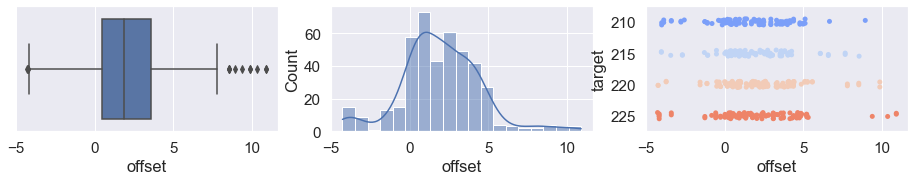

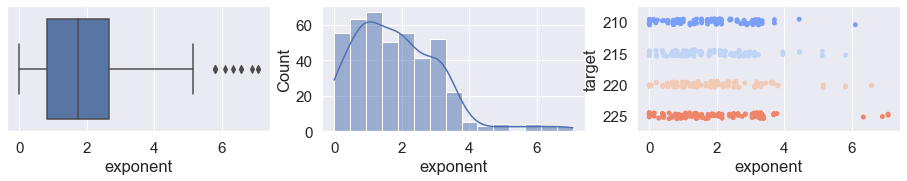

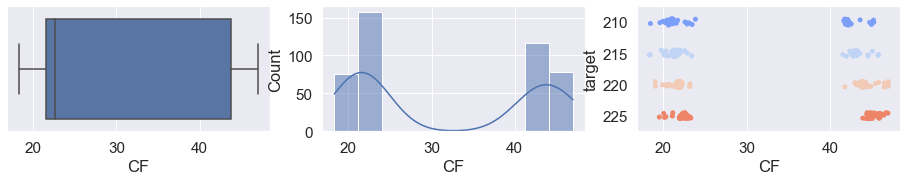

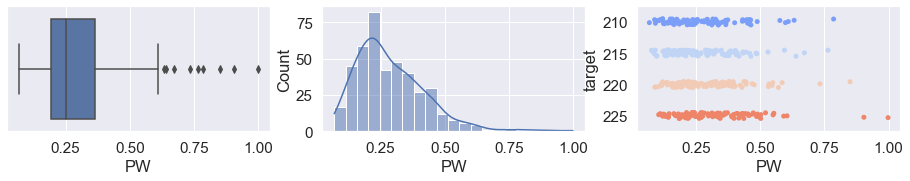

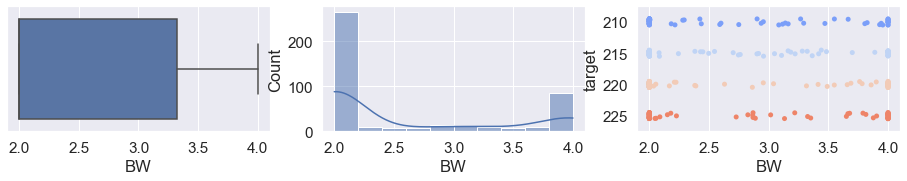

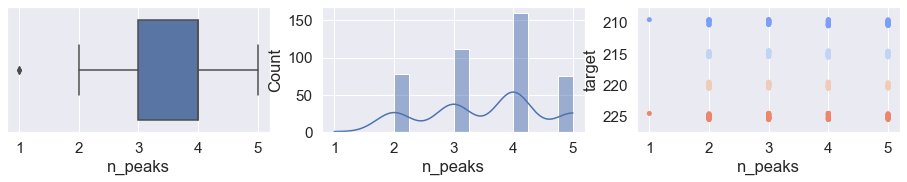

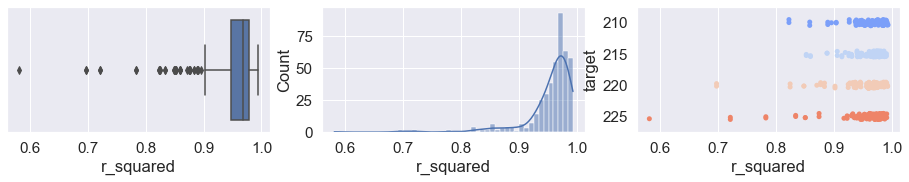

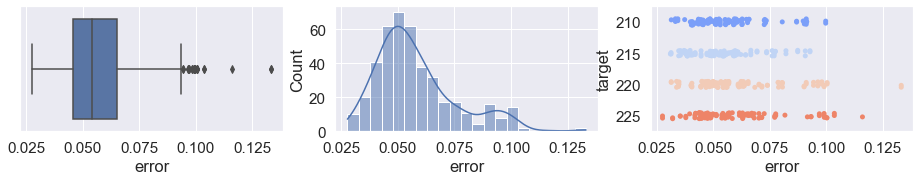

Done in 7.337s


In [11]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

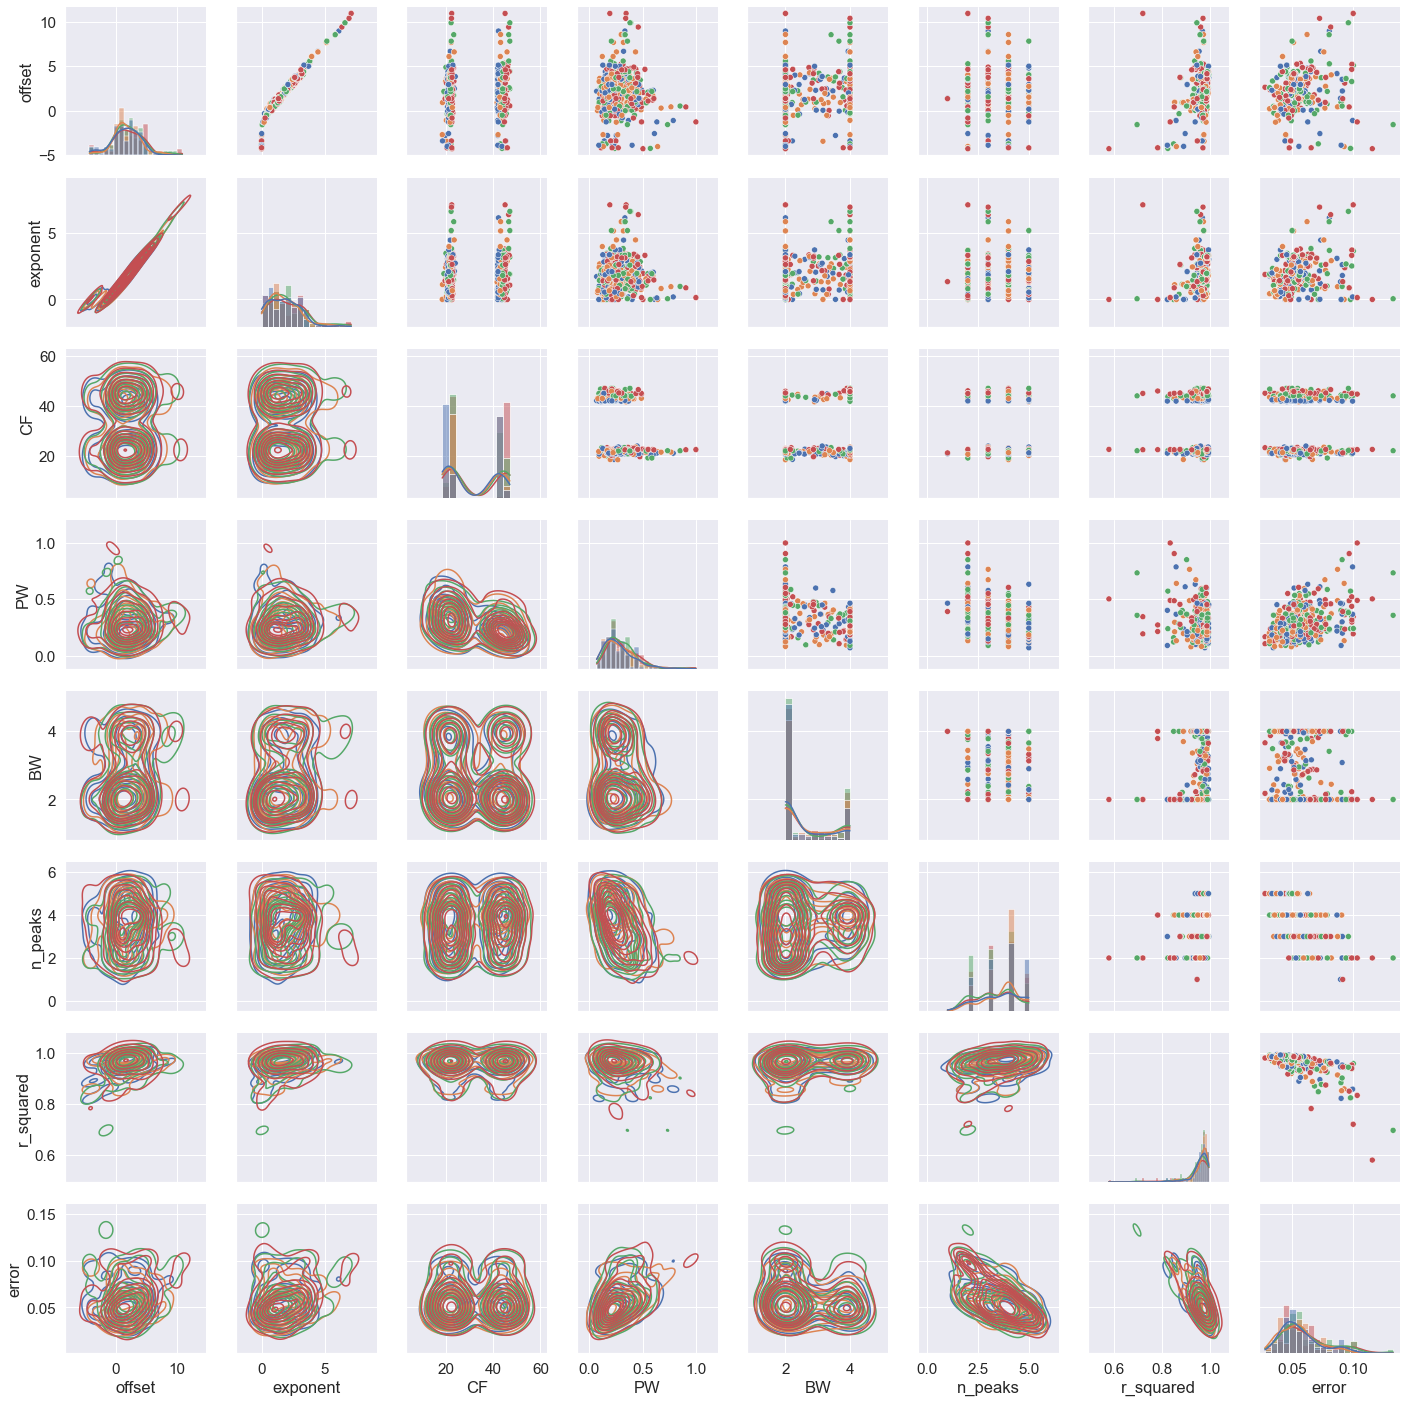

Done in 51.234s


In [12]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.26,0.97,0.06,-0.01,0.14,0.03,0.25,0.09
knee,0.26,1.00,0.29,0.01,-0.01,-0.04,-0.11,-0.35,0.17
exponent,0.97,0.29,1.00,0.06,0.01,0.17,-0.01,0.17,0.16
CF,0.06,0.01,0.06,1.00,-0.41,-0.08,0.06,-0.01,0.02
PW,-0.01,-0.01,0.01,-0.41,1.00,-0.12,-0.39,-0.22,0.44
BW,0.14,-0.04,0.17,-0.08,-0.12,1.00,0.04,0.10,-0.11
n_peaks,0.03,-0.11,-0.01,0.06,-0.39,0.04,1.00,0.32,-0.59
r_squared,0.25,-0.35,0.17,-0.01,-0.22,0.10,0.32,1.00,-0.65
error,0.09,0.17,0.16,0.02,0.44,-0.11,-0.59,-0.65,1.00


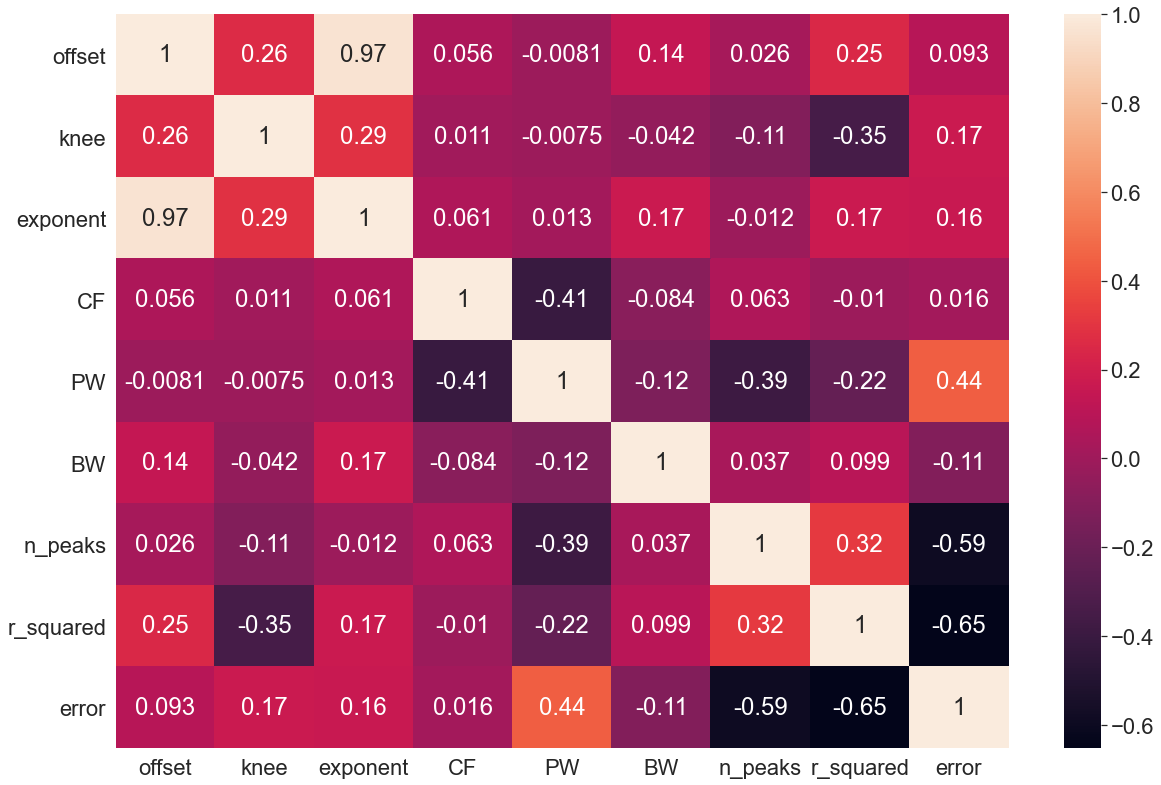

In [13]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [14]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -0.61357
Feature: 1, Score: -3.73971
Feature: 2, Score: 0.55906
Feature: 3, Score: -0.18301
Feature: 4, Score: -0.32137
Feature: 5, Score: -0.22274
Feature: 6, Score: 0.10108
Feature: 7, Score: 0.14083
Feature: 8, Score: 0.23806


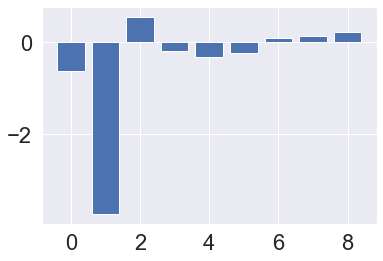

              precision    recall  f1-score   support

         210       0.19      0.20      0.20        20
         215       0.33      0.28      0.30        25
         220       0.35      0.31      0.33        26
         225       0.24      0.33      0.28        15

    accuracy                           0.28        86
   macro avg       0.28      0.28      0.28        86
weighted avg       0.29      0.28      0.28        86

Feature: 0, Score: -0.37187
Feature: 1, Score: -15.23089
Feature: 2, Score: 0.13587
Feature: 3, Score: -0.21997
Feature: 4, Score: -0.31959
Feature: 5, Score: -0.14460
Feature: 6, Score: 0.10563
Feature: 7, Score: 0.20036
Feature: 8, Score: 0.31115


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


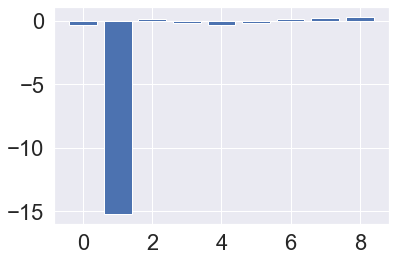

              precision    recall  f1-score   support

         210       0.19      0.22      0.21        18
         215       0.33      0.25      0.29        28
         220       0.36      0.35      0.36        23
         225       0.23      0.29      0.26        17

    accuracy                           0.28        86
   macro avg       0.28      0.28      0.28        86
weighted avg       0.29      0.28      0.28        86

Feature: 0, Score: -0.27669
Feature: 1, Score: -3.05238
Feature: 2, Score: 0.20782
Feature: 3, Score: -0.27894
Feature: 4, Score: -0.21179
Feature: 5, Score: -0.18033
Feature: 6, Score: 0.16073
Feature: 7, Score: 0.10389
Feature: 8, Score: 0.14641


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


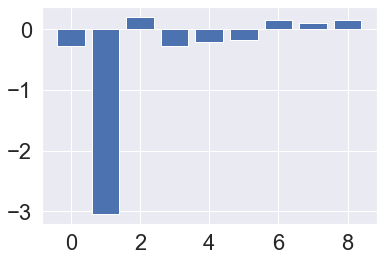

              precision    recall  f1-score   support

         210       0.29      0.40      0.33        15
         215       0.29      0.23      0.26        26
         220       0.23      0.22      0.22        23
         225       0.29      0.29      0.29        21

    accuracy                           0.27        85
   macro avg       0.27      0.28      0.27        85
weighted avg       0.27      0.27      0.27        85

Feature: 0, Score: -0.48860
Feature: 1, Score: -2.26874
Feature: 2, Score: 0.27295
Feature: 3, Score: -0.29969
Feature: 4, Score: -0.22913
Feature: 5, Score: -0.13606
Feature: 6, Score: 0.08498
Feature: 7, Score: 0.39696
Feature: 8, Score: 0.15118


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


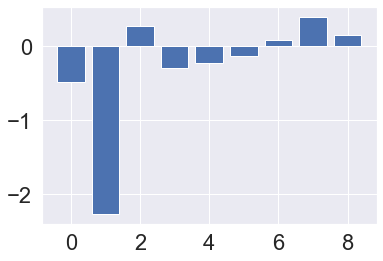

              precision    recall  f1-score   support

         210       0.24      0.26      0.25        19
         215       0.15      0.16      0.15        19
         220       0.26      0.21      0.24        28
         225       0.19      0.21      0.20        19

    accuracy                           0.21        85
   macro avg       0.21      0.21      0.21        85
weighted avg       0.22      0.21      0.21        85

Feature: 0, Score: -0.21094
Feature: 1, Score: -4.08958
Feature: 2, Score: 0.07259
Feature: 3, Score: -0.33626
Feature: 4, Score: -0.30656
Feature: 5, Score: -0.17580
Feature: 6, Score: -0.03661
Feature: 7, Score: 0.31404
Feature: 8, Score: 0.18404


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


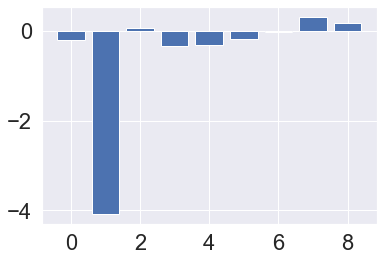

              precision    recall  f1-score   support

         210       0.50      0.27      0.35        37
         215       0.29      0.43      0.34        14
         220       0.39      0.50      0.44        18
         225       0.19      0.25      0.22        16

    accuracy                           0.34        85
   macro avg       0.34      0.36      0.34        85
weighted avg       0.38      0.34      0.34        85



In [15]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [16]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,17.4
knee,1.5
exponent,17.3
center of frequency,1.3
power,1.7
bandwidth,1.1
n peaks,1.7
R2,2.9
MAE,3.5


## 2. Ridge classifier

Feature: 0, Score: -0.00858
Feature: 1, Score: -0.00783
Feature: 2, Score: -0.00512
Feature: 3, Score: -0.00488
Feature: 4, Score: -0.01988
Feature: 5, Score: -0.02003
Feature: 6, Score: 0.01014
Feature: 7, Score: 0.00564
Feature: 8, Score: 0.00057


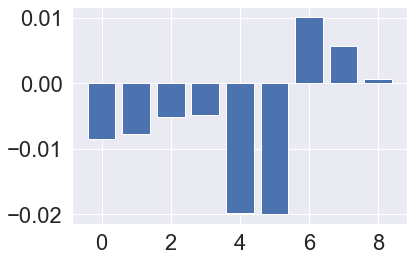

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.14      0.21      0.17        14
         215       0.29      0.21      0.24        28
         220       0.52      0.29      0.37        42
         225       0.00      0.00      0.00         2

    accuracy                           0.24        86
   macro avg       0.24      0.18      0.20        86
weighted avg       0.37      0.24      0.29        86

Feature: 0, Score: -0.01865
Feature: 1, Score: -0.00633
Feature: 2, Score: -0.01650
Feature: 3, Score: -0.01096
Feature: 4, Score: -0.01835
Feature: 5, Score: -0.01370
Feature: 6, Score: 0.00731
Feature: 7, Score: 0.00321
Feature: 8, Score: 0.00127


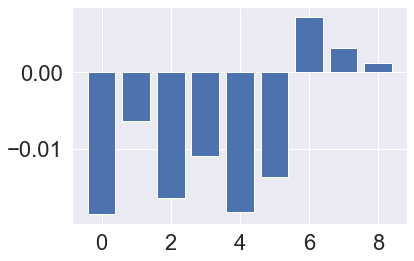

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.19      0.33      0.24        12
         215       0.19      0.24      0.21        17
         220       0.50      0.22      0.31        49
         225       0.05      0.12      0.07         8

    accuracy                           0.23        86
   macro avg       0.23      0.23      0.21        86
weighted avg       0.35      0.23      0.26        86

Feature: 0, Score: -0.09297
Feature: 1, Score: -0.00630
Feature: 2, Score: 0.05190
Feature: 3, Score: -0.12881
Feature: 4, Score: -0.09613
Feature: 5, Score: -0.08380
Feature: 6, Score: 0.07572
Feature: 7, Score: 0.05262
Feature: 8, Score: 0.06326


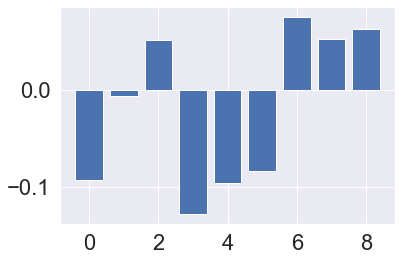

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         210       0.19      0.31      0.24        13
         215       0.29      0.23      0.26        26
         220       0.23      0.19      0.21        26
         225       0.24      0.25      0.24        20

    accuracy                           0.24        85
   macro avg       0.24      0.25      0.24        85
weighted avg       0.24      0.24      0.24        85

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000


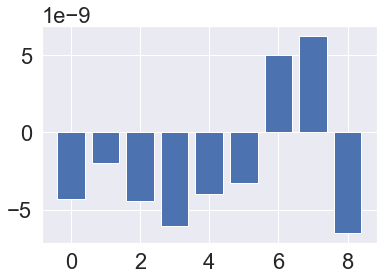

Alpha: 5000000000.0
              precision    recall  f1-score   support

         210       0.00      0.00      0.00         0
         215       0.00      0.00      0.00         0
         220       1.00      0.27      0.43        85
         225       0.00      0.00      0.00         0

    accuracy                           0.27        85
   macro avg       0.25      0.07      0.11        85
weighted avg       1.00      0.27      0.43        85

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


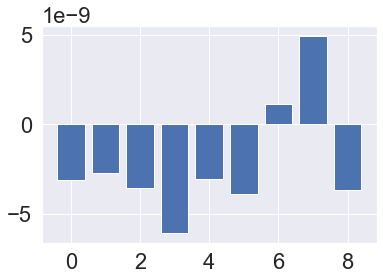

Alpha: 5000000000.0
              precision    recall  f1-score   support

         210       0.00      0.00      0.00         0
         215       0.00      0.00      0.00         0
         220       1.00      0.27      0.43        85
         225       0.00      0.00      0.00         0

    accuracy                           0.27        85
   macro avg       0.25      0.07      0.11        85
weighted avg       1.00      0.27      0.43        85



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.03256
Feature: 1, Score: 0.04651
Feature: 2, Score: 0.03721
Feature: 3, Score: -0.01395
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00465
Feature: 6, Score: -0.00930
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


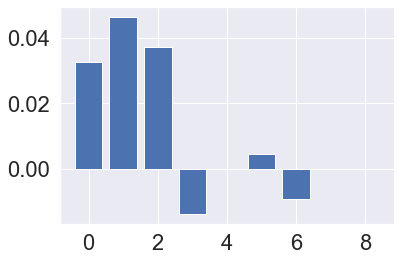

n_neighbors: 10
              precision    recall  f1-score   support

         210       0.24      0.17      0.20        30
         215       0.19      0.17      0.18        23
         220       0.13      0.14      0.13        22
         225       0.19      0.36      0.25        11

    accuracy                           0.19        86
   macro avg       0.19      0.21      0.19        86
weighted avg       0.19      0.19      0.18        86

Feature: 0, Score: -0.01860
Feature: 1, Score: 0.00233
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00930
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.01163
Feature: 6, Score: 0.02093
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


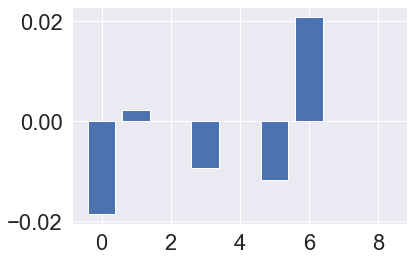

n_neighbors: 7
              precision    recall  f1-score   support

         210       0.33      0.22      0.26        32
         215       0.14      0.17      0.15        18
         220       0.18      0.17      0.18        23
         225       0.14      0.23      0.17        13

    accuracy                           0.20        86
   macro avg       0.20      0.20      0.19        86
weighted avg       0.22      0.20      0.20        86

Feature: 0, Score: 0.04235
Feature: 1, Score: 0.00235
Feature: 2, Score: 0.02118
Feature: 3, Score: 0.00941
Feature: 4, Score: 0.00941
Feature: 5, Score: -0.00000
Feature: 6, Score: 0.00706
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


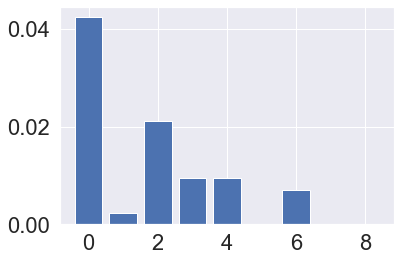

n_neighbors: 18
              precision    recall  f1-score   support

         210       0.29      0.22      0.25        27
         215       0.14      0.15      0.15        20
         220       0.27      0.22      0.24        27
         225       0.10      0.18      0.12        11

    accuracy                           0.20        85
   macro avg       0.20      0.19      0.19        85
weighted avg       0.22      0.20      0.21        85

Feature: 0, Score: -0.05412
Feature: 1, Score: -0.03765
Feature: 2, Score: -0.04706
Feature: 3, Score: -0.02588
Feature: 4, Score: -0.01412
Feature: 5, Score: -0.03294
Feature: 6, Score: 0.01882
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


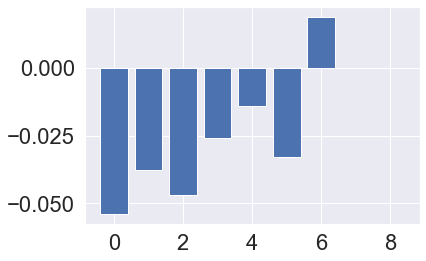

n_neighbors: 9
              precision    recall  f1-score   support

         210       0.05      0.05      0.05        19
         215       0.05      0.08      0.06        13
         220       0.22      0.16      0.18        32
         225       0.10      0.10      0.10        21

    accuracy                           0.11        85
   macro avg       0.10      0.10      0.10        85
weighted avg       0.12      0.11      0.11        85

Feature: 0, Score: 0.04706
Feature: 1, Score: 0.03294
Feature: 2, Score: 0.02588
Feature: 3, Score: 0.00706
Feature: 4, Score: 0.00471
Feature: 5, Score: 0.01647
Feature: 6, Score: 0.01176
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


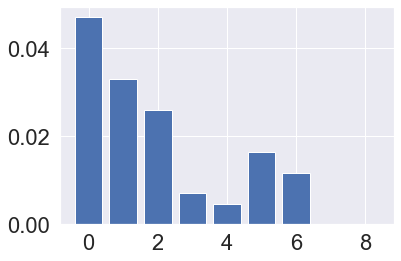

n_neighbors: 13
              precision    recall  f1-score   support

         210       0.35      0.18      0.24        38
         215       0.10      0.14      0.11        14
         220       0.09      0.10      0.09        21
         225       0.10      0.17      0.12        12

    accuracy                           0.15        85
   macro avg       0.16      0.15      0.14        85
weighted avg       0.21      0.15      0.17        85



In [18]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [19]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: identity
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.19      0.20      0.20        20
         215       0.33      0.28      0.30        25
         220       0.35      0.31      0.33        26
         225       0.24      0.33      0.28        15

    accuracy                           0.28        86
   macro avg       0.28      0.28      0.28        86
weighted avg       0.29      0.28      0.28        86

Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.29      0.32      0.30        19
         215       0.19      0.24      0.21        17
         220       0.27      0.19      0.23        31
         225       0.23      0.26      0.24        19

    accuracy                           0.24        86
   macro avg       0.24      0.25      0.25        86
weighted avg       0.25      0.24      0.24        86

Activation function: identity
Solver: adam
   

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. Random forest

Feature: 0, Score: 0.08236
Feature: 1, Score: 0.08614
Feature: 2, Score: 0.08052
Feature: 3, Score: 0.36073
Feature: 4, Score: 0.10542
Feature: 5, Score: 0.05065
Feature: 6, Score: 0.03384
Feature: 7, Score: 0.09560
Feature: 8, Score: 0.10474


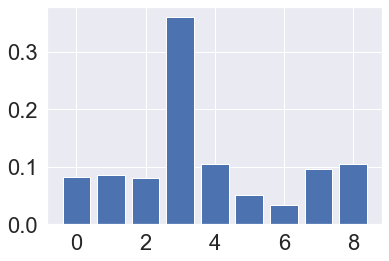

Number of trees: 2000
Maximum depth: 32
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.81      0.74      0.77        23
         215       0.76      0.84      0.80        19
         220       0.65      0.88      0.75        17
         225       0.95      0.74      0.83        27

    accuracy                           0.79        86
   macro avg       0.79      0.80      0.79        86
weighted avg       0.81      0.79      0.79        86

Feature: 0, Score: 0.08386
Feature: 1, Score: 0.08505
Feature: 2, Score: 0.08264
Feature: 3, Score: 0.38178
Feature: 4, Score: 0.10054
Feature: 5, Score: 0.05019
Feature: 6, Score: 0.02583
Feature: 7, Score: 0.08852
Feature: 8, Score: 0.10159


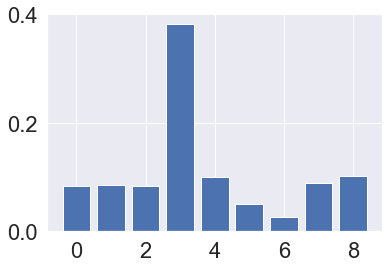

Number of trees: 1000
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.62      0.76      0.68        17
         215       0.67      0.58      0.62        24
         220       0.73      0.67      0.70        24
         225       0.68      0.71      0.70        21

    accuracy                           0.67        86
   macro avg       0.67      0.68      0.67        86
weighted avg       0.68      0.67      0.67        86

Feature: 0, Score: 0.08047
Feature: 1, Score: 0.09379
Feature: 2, Score: 0.08431
Feature: 3, Score: 0.36897
Feature: 4, Score: 0.09704
Feature: 5, Score: 0.04863
Feature: 6, Score: 0.03198
Feature: 7, Score: 0.09424
Feature: 8, Score: 0.10057


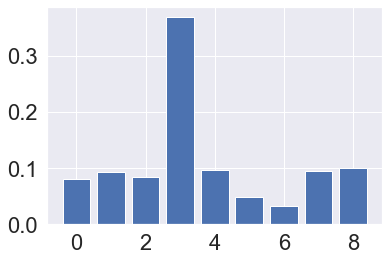

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.81      0.74      0.77        23
         215       0.62      0.65      0.63        20
         220       0.59      0.68      0.63        19
         225       0.81      0.74      0.77        23

    accuracy                           0.71        85
   macro avg       0.71      0.70      0.70        85
weighted avg       0.72      0.71      0.71        85

Feature: 0, Score: 0.08024
Feature: 1, Score: 0.08627
Feature: 2, Score: 0.08460
Feature: 3, Score: 0.35544
Feature: 4, Score: 0.10562
Feature: 5, Score: 0.05203
Feature: 6, Score: 0.02991
Feature: 7, Score: 0.09528
Feature: 8, Score: 0.11062


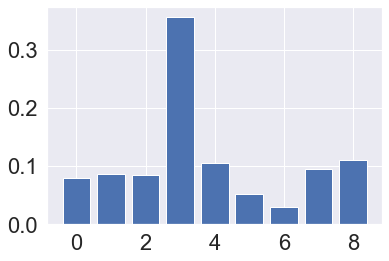

Number of trees: 200
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.71      0.71      0.71        21
         215       0.60      0.67      0.63        18
         220       0.65      0.71      0.68        21
         225       0.76      0.64      0.70        25

    accuracy                           0.68        85
   macro avg       0.68      0.68      0.68        85
weighted avg       0.69      0.68      0.68        85

Feature: 0, Score: 0.07741
Feature: 1, Score: 0.09245
Feature: 2, Score: 0.07761
Feature: 3, Score: 0.36895
Feature: 4, Score: 0.10044
Feature: 5, Score: 0.05677
Feature: 6, Score: 0.03082
Feature: 7, Score: 0.09362
Feature: 8, Score: 0.10192


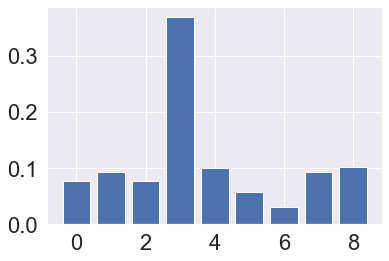

Number of trees: 200
Maximum depth: 77
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.85      0.68      0.76        25
         215       0.62      0.76      0.68        17
         220       0.78      0.72      0.75        25
         225       0.62      0.72      0.67        18

    accuracy                           0.72        85
   macro avg       0.72      0.72      0.71        85
weighted avg       0.74      0.72      0.72        85

Done in 1048.7272350788116 seconds


In [20]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 
    
print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [21]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [22]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_215, powers_220, powers_225), \
                                    (210, 215, 220, 225)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn2, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn2, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn2, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn2, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -3.4291, -1.0021, 0.0009                                     
                                                              

# IV. Classification
## Assign variables

In [23]:
# Number of observations
n_obs = len(df)

# Drop NA values
df = df.dropna()

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -0.31876
Feature: 1, Score: -0.34273
Feature: 2, Score: 0.14105
Feature: 3, Score: -0.23134
Feature: 4, Score: -0.26647
Feature: 5, Score: -0.13299
Feature: 6, Score: -0.02850
Feature: 7, Score: 0.26801
Feature: 8, Score: 0.21240


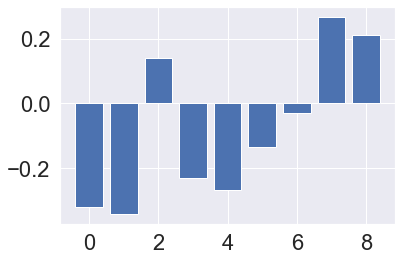

              precision    recall  f1-score   support

         210       0.36      0.29      0.32        52
         215       0.24      0.29      0.26        34
         220       0.24      0.23      0.24        47
         225       0.21      0.24      0.23        38

    accuracy                           0.26       171
   macro avg       0.26      0.26      0.26       171
weighted avg       0.27      0.26      0.27       171

Feature: 0, Score: -0.09991
Feature: 1, Score: -2.20769
Feature: 2, Score: -0.14368
Feature: 3, Score: -0.20715
Feature: 4, Score: -0.21827
Feature: 5, Score: -0.16970
Feature: 6, Score: -0.01783
Feature: 7, Score: 0.16836
Feature: 8, Score: 0.12856


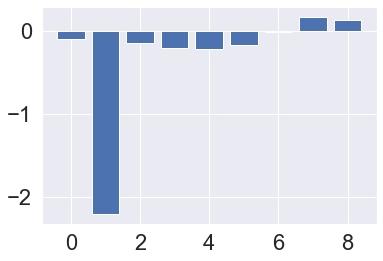

              precision    recall  f1-score   support

         210       0.43      0.41      0.42        44
         215       0.31      0.36      0.33        36
         220       0.42      0.29      0.34        66
         225       0.10      0.16      0.12        25

    accuracy                           0.32       171
   macro avg       0.31      0.30      0.30       171
weighted avg       0.35      0.32      0.33       171

Feature: 0, Score: -0.12270
Feature: 1, Score: -1.57112
Feature: 2, Score: 0.06049
Feature: 3, Score: -0.18441
Feature: 4, Score: -0.22382
Feature: 5, Score: -0.08079
Feature: 6, Score: -0.01023
Feature: 7, Score: 0.13660
Feature: 8, Score: 0.11697


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


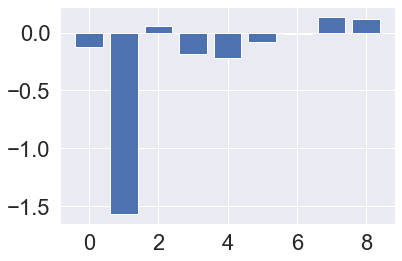

              precision    recall  f1-score   support

         210       0.29      0.38      0.32        32
         215       0.50      0.34      0.41        61
         220       0.24      0.28      0.26        40
         225       0.33      0.37      0.35        38

    accuracy                           0.34       171
   macro avg       0.34      0.34      0.34       171
weighted avg       0.36      0.34      0.34       171

Feature: 0, Score: -0.22492
Feature: 1, Score: -2.37411
Feature: 2, Score: 0.10042
Feature: 3, Score: -0.22801
Feature: 4, Score: -0.21418
Feature: 5, Score: -0.07200
Feature: 6, Score: -0.01935
Feature: 7, Score: 0.17435
Feature: 8, Score: 0.14520


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


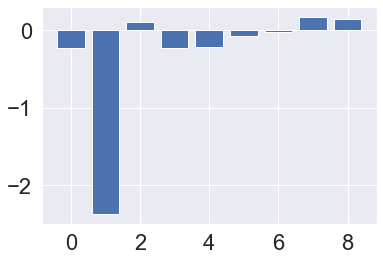

              precision    recall  f1-score   support

         210       0.24      0.28      0.26        36
         215       0.46      0.40      0.43        48
         220       0.33      0.29      0.31        52
         225       0.17      0.20      0.18        35

    accuracy                           0.30       171
   macro avg       0.30      0.29      0.29       171
weighted avg       0.31      0.30      0.30       171

Feature: 0, Score: -0.16232
Feature: 1, Score: -0.68219
Feature: 2, Score: -0.00782
Feature: 3, Score: -0.19857
Feature: 4, Score: -0.30291
Feature: 5, Score: -0.15734
Feature: 6, Score: 0.06637
Feature: 7, Score: 0.22035
Feature: 8, Score: 0.21485


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


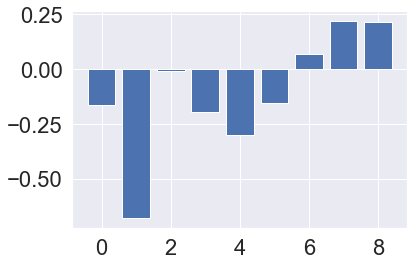

              precision    recall  f1-score   support

         210       0.34      0.26      0.30        53
         215       0.26      0.26      0.26        43
         220       0.31      0.27      0.29        51
         225       0.26      0.48      0.34        23

    accuracy                           0.29       170
   macro avg       0.29      0.32      0.30       170
weighted avg       0.30      0.29      0.29       170



In [24]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [25]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,14.0
knee,1.2
exponent,14.5
center of frequency,1.3
power,1.8
bandwidth,1.1
n peaks,1.6
R2,2.1
MAE,3.0


## 2. Ridge classifier

Feature: 0, Score: -0.07724
Feature: 1, Score: 0.00157
Feature: 2, Score: 0.00049
Feature: 3, Score: -0.08989
Feature: 4, Score: -0.09910
Feature: 5, Score: -0.05585
Feature: 6, Score: -0.01565
Feature: 7, Score: 0.08827
Feature: 8, Score: 0.06053


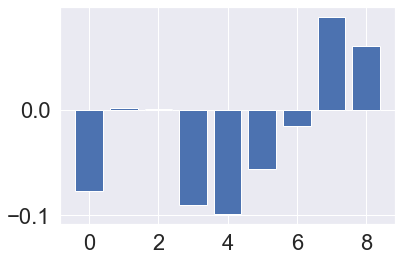

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.31      0.29      0.30        45
         215       0.33      0.34      0.34        41
         220       0.31      0.25      0.28        56
         225       0.17      0.24      0.20        29

    accuracy                           0.28       171
   macro avg       0.28      0.28      0.28       171
weighted avg       0.29      0.28      0.28       171

Feature: 0, Score: -0.00277
Feature: 1, Score: -0.00102
Feature: 2, Score: -0.00285
Feature: 3, Score: -0.00167
Feature: 4, Score: -0.00111
Feature: 5, Score: -0.00184
Feature: 6, Score: 0.00030
Feature: 7, Score: 0.00099
Feature: 8, Score: -0.00122


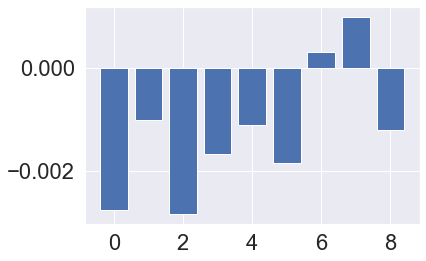

Alpha: 23207.94416806391
              precision    recall  f1-score   support

         210       0.00      0.00      0.00         0
         215       0.00      0.00      0.00         0
         220       1.00      0.26      0.42       171
         225       0.00      0.00      0.00         0

    accuracy                           0.26       171
   macro avg       0.25      0.07      0.10       171
weighted avg       1.00      0.26      0.42       171

Feature: 0, Score: -0.02890
Feature: 1, Score: -0.01411
Feature: 2, Score: -0.00630
Feature: 3, Score: -0.07420
Feature: 4, Score: -0.08658
Feature: 5, Score: -0.03514
Feature: 6, Score: -0.00544
Feature: 7, Score: 0.05291
Feature: 8, Score: 0.03565


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


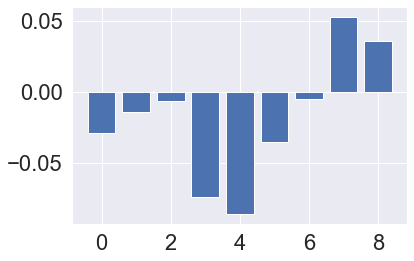

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.26      0.34      0.30        32
         215       0.43      0.32      0.37        56
         220       0.29      0.26      0.27        50
         225       0.31      0.39      0.35        33

    accuracy                           0.32       171
   macro avg       0.32      0.33      0.32       171
weighted avg       0.33      0.32      0.32       171

Feature: 0, Score: -0.01714
Feature: 1, Score: -0.00785
Feature: 2, Score: -0.01483
Feature: 3, Score: -0.02999
Feature: 4, Score: -0.01698
Feature: 5, Score: -0.00791
Feature: 6, Score: -0.00143
Feature: 7, Score: 0.01526
Feature: 8, Score: -0.00450


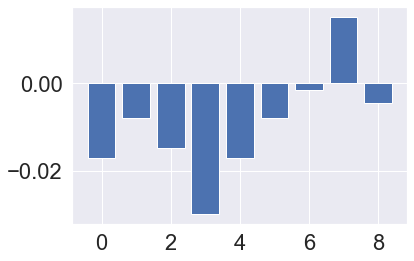

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.14      0.25      0.18        24
         215       0.34      0.33      0.33        43
         220       0.46      0.28      0.35        75
         225       0.17      0.24      0.20        29

    accuracy                           0.28       171
   macro avg       0.28      0.27      0.26       171
weighted avg       0.33      0.28      0.30       171

Feature: 0, Score: -0.07139
Feature: 1, Score: -0.00125
Feature: 2, Score: -0.01044
Feature: 3, Score: -0.09157
Feature: 4, Score: -0.13940
Feature: 5, Score: -0.07656
Feature: 6, Score: 0.03409
Feature: 7, Score: 0.09904
Feature: 8, Score: 0.09871


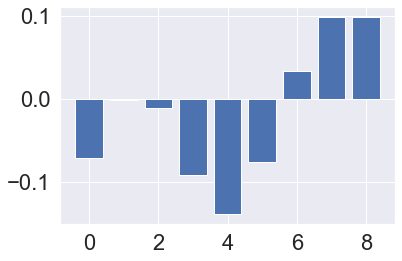

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         210       0.34      0.25      0.29        56
         215       0.24      0.24      0.24        41
         220       0.31      0.28      0.29        50
         225       0.24      0.43      0.31        23

    accuracy                           0.28       170
   macro avg       0.28      0.30      0.28       170
weighted avg       0.29      0.28      0.28       170



In [26]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.01871
Feature: 1, Score: 0.03626
Feature: 2, Score: 0.01404
Feature: 3, Score: 0.01520
Feature: 4, Score: 0.00234
Feature: 5, Score: 0.00351
Feature: 6, Score: 0.00936
Feature: 7, Score: 0.00351
Feature: 8, Score: 0.00117


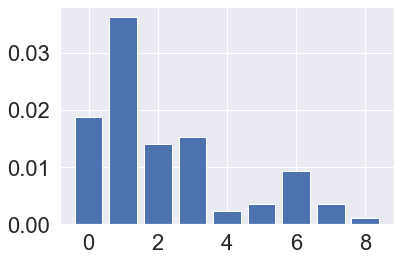

n_neighbors: 13
              precision    recall  f1-score   support

         210       0.29      0.26      0.27        47
         215       0.26      0.25      0.26        44
         220       0.22      0.23      0.23        43
         225       0.17      0.19      0.18        37

    accuracy                           0.23       171
   macro avg       0.23      0.23      0.23       171
weighted avg       0.24      0.23      0.24       171

Feature: 0, Score: -0.02105
Feature: 1, Score: 0.00234
Feature: 2, Score: -0.01871
Feature: 3, Score: -0.01637
Feature: 4, Score: -0.00819
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00819
Feature: 7, Score: -0.00234
Feature: 8, Score: -0.00234


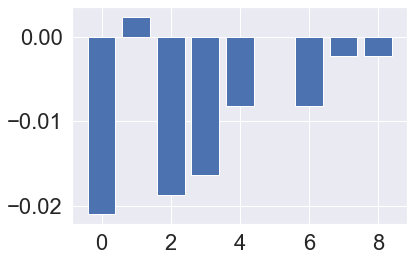

n_neighbors: 15
              precision    recall  f1-score   support

         210       0.36      0.25      0.29        60
         215       0.17      0.21      0.18        34
         220       0.22      0.24      0.23        41
         225       0.26      0.31      0.28        36

    accuracy                           0.25       171
   macro avg       0.25      0.25      0.25       171
weighted avg       0.27      0.25      0.25       171

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.04561
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


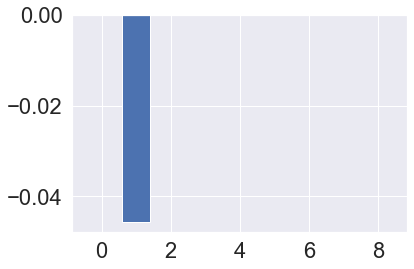

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.12      0.14      0.13        37
         215       0.19      0.19      0.19        42
         220       0.22      0.23      0.22        44
         225       0.24      0.21      0.22        48

    accuracy                           0.19       171
   macro avg       0.19      0.19      0.19       171
weighted avg       0.20      0.19      0.19       171

Feature: 0, Score: 0.01053
Feature: 1, Score: 0.03041
Feature: 2, Score: 0.00936
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00117
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


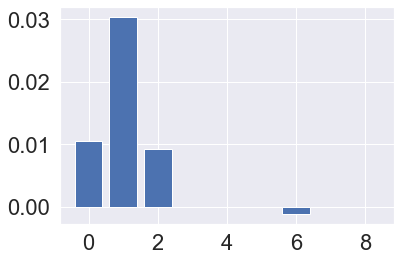

n_neighbors: 3
              precision    recall  f1-score   support

         210       0.43      0.24      0.31        74
         215       0.27      0.23      0.25        47
         220       0.04      0.08      0.06        24
         225       0.19      0.31      0.24        26

    accuracy                           0.23       171
   macro avg       0.23      0.22      0.21       171
weighted avg       0.29      0.23      0.25       171

Feature: 0, Score: 0.02471
Feature: 1, Score: 0.02118
Feature: 2, Score: 0.02824
Feature: 3, Score: 0.04235
Feature: 4, Score: 0.00588
Feature: 5, Score: 0.00824
Feature: 6, Score: 0.02706
Feature: 7, Score: 0.00353
Feature: 8, Score: 0.00471


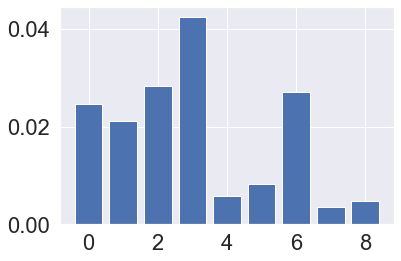

n_neighbors: 17
              precision    recall  f1-score   support

         210       0.27      0.26      0.27        42
         215       0.29      0.22      0.25        55
         220       0.27      0.26      0.26        46
         225       0.21      0.33      0.26        27

    accuracy                           0.26       170
   macro avg       0.26      0.27      0.26       170
weighted avg       0.26      0.26      0.26       170



In [27]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [28]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: tanh
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.21      0.22      0.22        41
         215       0.26      0.25      0.26        44
         220       0.47      0.41      0.44        51
         225       0.29      0.34      0.31        35

    accuracy                           0.31       171
   macro avg       0.31      0.31      0.31       171
weighted avg       0.32      0.31      0.31       171



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.17      0.21      0.18        34
         215       0.29      0.26      0.27        47
         220       0.36      0.33      0.34        48
         225       0.38      0.38      0.38        42

    accuracy                           0.30       171
   macro avg       0.30      0.29      0.29       171
weighted avg       0.31      0.30      0.30       171



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.40      0.33      0.36        52
         215       0.26      0.24      0.25        45
         220       0.22      0.24      0.23        41
         225       0.21      0.27      0.24        33

    accuracy                           0.27       171
   macro avg       0.28      0.27      0.27       171
weighted avg       0.29      0.27      0.28       171



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: relu
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.36      0.44      0.39        34
         215       0.37      0.33      0.34        46
         220       0.35      0.32      0.33        50
         225       0.33      0.34      0.34        41

    accuracy                           0.35       171
   macro avg       0.35      0.36      0.35       171
weighted avg       0.35      0.35      0.35       171

Activation function: tanh
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.20      0.26      0.22        31
         215       0.29      0.24      0.26        51
         220       0.33      0.32      0.33        47
         225       0.38      0.39      0.39        41

    accuracy                           0.30       170
   macro avg       0.30      0.30      0.30       170
weighted avg       0.31      0.30      0.30       170



## 5. Random forest

Feature: 0, Score: 0.08246
Feature: 1, Score: 0.08496
Feature: 2, Score: 0.08025
Feature: 3, Score: 0.39567
Feature: 4, Score: 0.09812
Feature: 5, Score: 0.04831
Feature: 6, Score: 0.03023
Feature: 7, Score: 0.08697
Feature: 8, Score: 0.09304


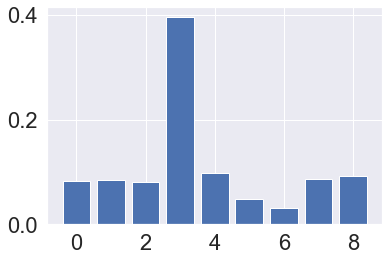

Number of trees: 2000
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.83      0.78      0.80        45
         215       0.71      0.79      0.75        38
         220       0.80      0.82      0.81        44
         225       0.81      0.77      0.79        44

    accuracy                           0.79       171
   macro avg       0.79      0.79      0.79       171
weighted avg       0.79      0.79      0.79       171

Feature: 0, Score: 0.08140
Feature: 1, Score: 0.07933
Feature: 2, Score: 0.07907
Feature: 3, Score: 0.40425
Feature: 4, Score: 0.09253
Feature: 5, Score: 0.05293
Feature: 6, Score: 0.03030
Feature: 7, Score: 0.08353
Feature: 8, Score: 0.09667


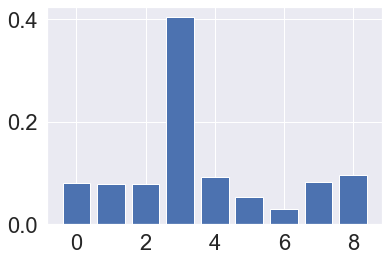

Number of trees: 200
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.69      0.69      0.69        42
         215       0.57      0.65      0.61        37
         220       0.82      0.76      0.79        49
         225       0.83      0.81      0.82        43

    accuracy                           0.73       171
   macro avg       0.73      0.73      0.73       171
weighted avg       0.74      0.73      0.73       171

Feature: 0, Score: 0.08307
Feature: 1, Score: 0.08292
Feature: 2, Score: 0.08318
Feature: 3, Score: 0.40129
Feature: 4, Score: 0.09495
Feature: 5, Score: 0.04890
Feature: 6, Score: 0.03180
Feature: 7, Score: 0.08486
Feature: 8, Score: 0.08905


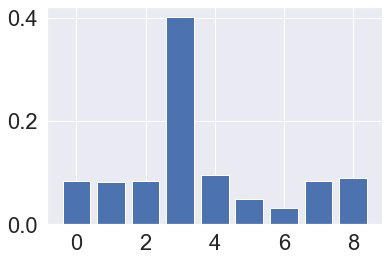

Number of trees: 1000
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.86      0.75      0.80        48
         215       0.67      0.74      0.70        38
         220       0.82      0.82      0.82        45
         225       0.86      0.90      0.88        40

    accuracy                           0.80       171
   macro avg       0.80      0.80      0.80       171
weighted avg       0.81      0.80      0.80       171

Feature: 0, Score: 0.07987
Feature: 1, Score: 0.08762
Feature: 2, Score: 0.08006
Feature: 3, Score: 0.40886
Feature: 4, Score: 0.09664
Feature: 5, Score: 0.04879
Feature: 6, Score: 0.02972
Feature: 7, Score: 0.08053
Feature: 8, Score: 0.08790


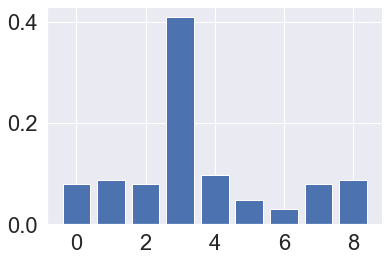

Number of trees: 2000
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.71      0.79      0.75        38
         215       0.63      0.70      0.67        37
         220       0.80      0.77      0.79        48
         225       0.83      0.73      0.78        48

    accuracy                           0.75       171
   macro avg       0.75      0.75      0.75       171
weighted avg       0.76      0.75      0.75       171

Feature: 0, Score: 0.07701
Feature: 1, Score: 0.08573
Feature: 2, Score: 0.07901
Feature: 3, Score: 0.40920
Feature: 4, Score: 0.09675
Feature: 5, Score: 0.04886
Feature: 6, Score: 0.03192
Feature: 7, Score: 0.08416
Feature: 8, Score: 0.08735


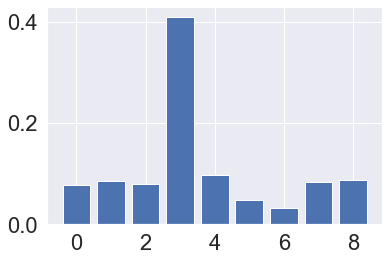

Number of trees: 1000
Maximum depth: 55
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.73      0.73      0.73        41
         215       0.71      0.75      0.73        40
         220       0.69      0.79      0.74        39
         225       0.83      0.70      0.76        50

    accuracy                           0.74       170
   macro avg       0.74      0.74      0.74       170
weighted avg       0.75      0.74      0.74       170

Done in 849.3434698581696 seconds


In [29]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    
    
print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [30]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table6.csv')
performance.to_csv('performance_table6.csv')

# Display
display(performance)
display(df)

,accuracy,precision,recall,classifier,n_channels,table
0,0.28,0.29,0.28,log,13,6
1,0.28,0.29,0.28,log,13,6
2,0.27,0.27,0.27,log,13,6
3,0.21,0.22,0.21,log,13,6
4,0.34,0.38,0.34,log,13,6
5,0.24,0.37,0.24,ridge,13,6
6,0.23,0.35,0.23,ridge,13,6
7,0.24,0.24,0.24,ridge,13,6
8,0.27,1.00,0.27,ridge,13,6
9,0.27,1.00,0.27,ridge,13,6


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,210,-2.786069,-1.013677,0.005934,19.586790,0.252773,3.550318,3,0.971973,0.044624
1,S1,/Day1,210,-2.786069,-1.013677,0.005934,41.879070,0.170783,2.000000,3,0.971973,0.044624
2,S1,/Day1,215,-3.434262,-1.003559,0.001554,20.185457,0.223581,3.162583,3,0.973995,0.044684
3,S1,/Day1,220,-1.130506,-1.598865,0.205102,21.920685,0.298087,2.000000,3,0.971127,0.049268
4,S1,/Day1,220,-1.130506,-1.598865,0.205102,44.270840,0.183592,2.000000,3,0.971127,0.049268
...,...,...,...,...,...,...,...,...,...,...,...,...
849,S30,/Day2,215,5.583467,361304.375000,3.439167,42.913445,0.157445,2.000000,4,0.924883,0.042138
850,S30,/Day2,220,4.742969,40169.644531,2.990928,21.825737,0.407879,2.000000,2,0.747785,0.094793
851,S30,/Day2,220,4.742969,40169.644531,2.990928,43.936222,0.297815,2.000000,2,0.747785,0.094793
852,S30,/Day2,225,4.936471,60133.250000,3.133779,22.458595,0.490867,2.000000,2,0.771967,0.097636


In [31]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.232     0.252  0.232
           13            0.170     0.192  0.170
MLP        3             0.306     0.316  0.306
           13            0.250     0.404  0.250
RF         3             0.762     0.770  0.762
           13            0.714     0.728  0.714
log        3             0.302     0.318  0.302
           13            0.276     0.290  0.276
ridge      3             0.284     0.448  0.284
           13            0.250     0.592  0.250

log 13


accuracy     0.018461
precision    0.023152
recall       0.018461
dtype: float64

log 3


accuracy     0.012133
precision    0.014805
recall       0.012133
dtype: float64

Ridge 13


accuracy     0.007483
precision    0.150290
recall       0.007483
dtype: float64

Ridge 3


accuracy     0.008764
precision    0.123690
recall       0.008764
dtype: float64

KNN 13


accuracy     0.015748
precision    0.016829
recall       0.015748
dtype: float64

KNN 3


accuracy     0.010733
precision    0.013682
recall       0.010733
dtype: float64

MLP 13


accuracy     0.014697
precision    0.134003
recall       0.014697
dtype: float64

MLP 3


accuracy     0.011524
precision    0.008764
recall       0.011524
dtype: float64

RF 13


accuracy     0.018889
precision    0.020669
recall       0.018889
dtype: float64

RF 3


accuracy     0.012458
precision    0.011662
recall       0.012458
dtype: float64

In [32]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),1.884332,4.0,408.571527,7.530606e-32
C(n_channels),0.025538,1.0,22.149172,3.003734e-05
C(classifier):C(n_channels),0.002252,4.0,0.488292,7.442411e-01
Residual,0.046120,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.077  0.001  0.0255  0.1285   True
   KNN     RF    0.537  0.001  0.4855  0.5885   True
   KNN    log    0.088  0.001  0.0365  0.1395   True
   KNN  ridge    0.066  0.006  0.0145  0.1175   True
   MLP     RF     0.46  0.001  0.4085  0.5115   True
   MLP    log    0.011    0.9 -0.0405  0.0625  False
   MLP  ridge   -0.011    0.9 -0.0625  0.0405  False
    RF    log   -0.449  0.001 -0.5005 -0.3975   True
    RF  ridge   -0.471  0.001 -0.5225 -0.4195   True
   log  ridge   -0.022 0.7184 -0.0735  0.0295  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3     13  -0.0452 0.4297 -0.1593 0.0689  False
--------------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),1.738960,4.0,12.053344,0.000002
C(n_channels),0.005202,1.0,0.144228,0.706123
C(classifier):C(n_channels),0.081368,4.0,0.563990,0.690145
Residual,1.442720,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.138 0.4613 -0.0963  0.3723  False
   KNN     RF    0.527  0.001  0.2927  0.7613   True
   KNN    log    0.082 0.8399 -0.1523  0.3163  False
   KNN  ridge    0.298 0.0065  0.0637  0.5323   True
   MLP     RF    0.389  0.001  0.1547  0.6233   True
   MLP    log   -0.056    0.9 -0.2903  0.1783  False
   MLP  ridge     0.16 0.3115 -0.0743  0.3943  False
    RF    log   -0.445  0.001 -0.6793 -0.2107   True
    RF  ridge   -0.229 0.0583 -0.4633  0.0053  False
   log  ridge    0.216 0.0838 -0.0183  0.4503  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3     13   0.0204 0.7913 -0.1279 0.1687  False
--------------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),1.884332,4.0,408.571527,7.530606e-32
C(n_channels),0.025538,1.0,22.149172,3.003734e-05
C(classifier):C(n_channels),0.002252,4.0,0.488292,7.442411e-01
Residual,0.046120,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.077  0.001  0.0255  0.1285   True
   KNN     RF    0.537  0.001  0.4855  0.5885   True
   KNN    log    0.088  0.001  0.0365  0.1395   True
   KNN  ridge    0.066  0.006  0.0145  0.1175   True
   MLP     RF     0.46  0.001  0.4085  0.5115   True
   MLP    log    0.011    0.9 -0.0405  0.0625  False
   MLP  ridge   -0.011    0.9 -0.0625  0.0405  False
    RF    log   -0.449  0.001 -0.5005 -0.3975   True
    RF  ridge   -0.471  0.001 -0.5225 -0.4195   True
   log  ridge   -0.022 0.7184 -0.0735  0.0295  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3     13  -0.0452 0.4297 -0.1593 0.0689  False
--------------------------------------------------